In [219]:
import os
import sys
import numpy as np

import time
import json
import yaml
import pickle
import math
import shutil
import hydra

from tqdm import tqdm
from datetime import datetime
from omegaconf import DictConfig, OmegaConf
from collections import defaultdict, Counter, deque
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets.dataset import LaserImageDataset, get_transforms
from datasets.preprocess import load_labels
from visualization.vis_utils import generate_html, plot_damaged_dets
from models.network import Network

from utils.metrics import MetricLogger
from utils.misc import create_new_dir, copy_src, save_file
from utils.utils import set_random_seed, model_parameters

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify the experiment to evaluate

In [258]:
session = '002'
# exp_dir = 'exp1_PointCNN_Grating_A6_Grating_SON1_LASEROPTIK_LASEROPTIK_SON1_seed3061994_lr0.0003_e500_b64'
# exp_dir = 'exp2_THALES_SESO_10000_THALES_SESO_A_MLP_seed3061994_lr0.0003_e500_b32'
# exp_dir = 'exp3_THALES_SESO_10000_THALES_SESO_A_PointCNN_lr0.0003_e500_b32'
# exp_dir = 'exp3_LASEROPTIK_SON1_LASEROPTIK_LASEROPTIK_10000_PointCNN_lr0.0003_e500_b32'
# exp_dir = 'exp3_Grating_A6_Grating_SON1_PointCNN_lr0.0003_e500_b32'

# exp_dir = 'exp4_Grating_A6_PointCNN_lr0.0003_e500_b32'
# exp_dir = 'exp4_Grating_SON1_PointCNN_lr0.0003_e500_b32'
# exp_dir = 'exp4_LASEROPTIK_PointCNN_lr0.0003_e500_b32'
# exp_dir = 'exp4_LASEROPTIK_SON1_PointCNN_lr0.0003_e500_b32'
# exp_dir = 'exp4_LASEROPTIK_10000_PointCNN_lr0.0003_e500_b32'
# exp_dir = 'exp4_THALES_SESO_A_PointCNN_lr0.0003_e500_b32'
# exp_dir = 'exp4_THALES_SESO_10000_PointCNN_lr0.0003_e500_b32'

exp_dir = 'exp6_augphoto0.5_PointCNN_lr0.0003_e500_b32'

# test_dataset = 'Grating_A6'
# test_dataset = 'Grating_SON1'
test_dataset = 'LASEROPTIK'
# test_dataset = 'LASEROPTIK_10000'
# test_dataset = 'LASEROPTIK_SON1'
# test_dataset = 'THALES_SESO_10000'
# test_dataset = 'THALES_SESO_A'

log_dir = f"../logs/session{session}/{exp_dir}/{test_dataset}"
ckpt_dir = log_dir + "/checkpoints"

if not os.path.exists(log_dir):
    raise Exception(f"{log_dir} doesn't exists")

print("Evaluating exp :", log_dir)

Evaluating exp : ../logs/session002/exp6_augphoto0.5_PointCNN_lr0.0003_e500_b32/LASEROPTIK


## Load cfg 

In [260]:
# load config
cfg = OmegaConf.load(log_dir + '/cfg.yaml')
# print(OmegaConf.to_yaml(cfg))

## Load model from checkpoint

In [261]:
ckpt_name = 'best_acc'
print("Loading Checkpoint from ", ckpt_dir + '/' + ckpt_name)
network = Network(cfg)
print(network)

states = torch.load(ckpt_dir + '/' + ckpt_name + '.pth')
if ckpt_name == 'model_states':
    states = states['model_state']

network.load_state_dict(states, strict=True)
network = network.eval()
print("Model loaded sucessfully!")

Loading Checkpoint from  ../logs/session002/exp6_augphoto0.5_PointCNN_lr0.0003_e500_b32/LASEROPTIK/checkpoints/best_acc
Network(
  (net): PointCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (res1_conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1_conv2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (res1_conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2_conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2_conv2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (res2_conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2_skip): Conv2d(256, 512, kernel_size=(1, 

## Create dataloader

In [262]:
# eval_datasets = ['Grating_A6']
# eval_datasets = ['THALES_SESO_A']
# eval_datasets = ['THALES_SESO_A', 'THALES_SESO_10000']
print(cfg.data.test_datasets)

cfg.data.prefetch = False

eval_dataset = LaserImageDataset(cfg,
                                 phase='test',
                                 img_labels=load_labels(cfg.data.data_dir, cfg.data.test_datasets),
                                 img_transform=get_transforms(cfg.data, "eval"),
                                )
eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False, num_workers=1)

print(f"Evaluation samples: {len(eval_dataset)}, Bathces: {len(eval_dataloader)}")


['LASEROPTIK']
Class 0: 4113/5500 test samples
Class 1: 1387/5500 test samples
Evaluation samples: 5500, Bathces: 86


## Preparation

In [263]:
set_random_seed(cfg.exp.seed)

device = torch.device("cuda:0")
network = network.to(device)

date_time = datetime.now().strftime("%d%m%Y")
# date_time = datetime.now().strftime("%d%m%Y_%H%M%S")

# result_dir = log_dir + f"/evaluations/{date_time}"
result_dir = log_dir + "/evaluations"

## Evaluate

  0%|          | 0/86 [00:00<?, ?it/s]

Evaluating ../logs/session002/exp6_augphoto0.5_PointCNN_lr0.0003_e500_b32/LASEROPTIK


100%|██████████| 86/86 [00:18<00:00,  4.66it/s, 1.000000]

Metric           tp       fp       tn       fn       accuracy    precision    recall    f1
---------------  -------  -------  -------  -------  ----------  -----------  --------  -------
binary_accuracy  1375.00  0.00     4113.00  12.00    1.00        1.00         0.99      1.00
-------          -------  -------  -------  -------  -------     -------      -------   -------


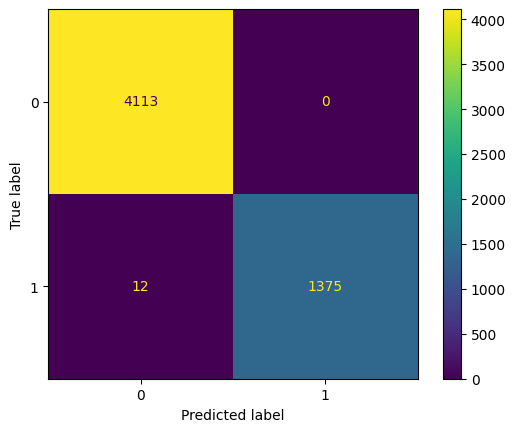

In [264]:
from utils.metrics import MetricLogger
# from torchmetrics.classification import BinaryAccuracy
# eval_metrics = BinaryAccuracy().to(device)

eval_metrics = MetricLogger()

eval_results = []
pbar = tqdm(total=len(eval_dataloader), position=0)
print('Evaluating', log_dir)
with torch.no_grad():
    for iter, batch in enumerate(eval_dataloader):
        pbar.update(1)

        imgs, labels, img_files = batch

        imgs = imgs.to(device)
        labels = labels.to(device)

        preds = network(imgs)
        preds = F.softmax(preds, dim=-1)
        
        acc = eval_metrics(preds.argmax(-1).to(device), labels.argmax(-1).to(device))
        # acc = eval_metrics.update(preds.to(device), labels.to(device))

        for f, l, p in zip(img_files, labels, preds):
            eval_results.append(dict(img=f, label=l.argmax().item(), pred=p.argmax().item(), prob=p.max().item()))
            
        pbar.set_postfix_str(f"{acc:03f}")
        # break

eval_metrics.compute()

try:
    cm = confusion_matrix([item['label'] for item in eval_results], [item['pred'] for item in eval_results])
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()
    disp.figure_.savefig(log_dir + '/eval_confusion_matrix.png')
except:
    pass

with open(log_dir + '/eval_metric_results.txt', 'w') as f:
    json.dump(eval_metrics.results, f)
    
with open(log_dir+'/eval_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)

data_dir = os.path.join(os.getcwd(), "../data/near_field/images/")
html_data = generate_html(eval_results, data_dir, title="Eval Results", save_dir=log_dir)


##  Remove some false positives and test on real dataset

In [256]:
# load eval results
with open(f"../logs/session002/{exp_dir}/THALES_SESO_A/eval_results.pkl", 'rb') as f:
    eval_results = pickle.load(f)
    

Mean ACC: 99.53, Mean Delay: 3.11secs


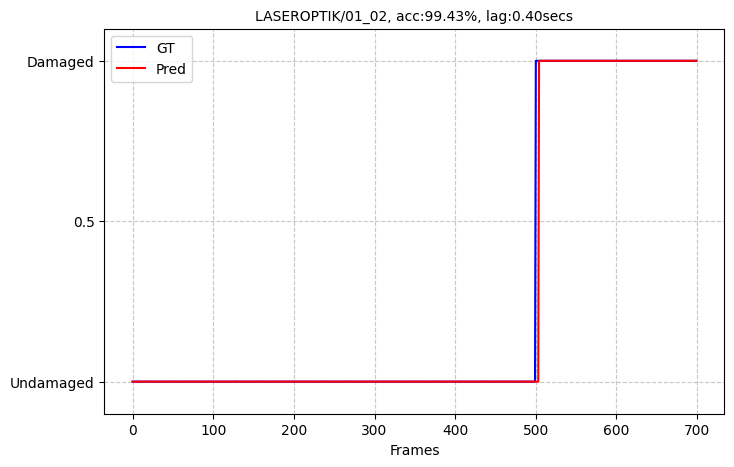

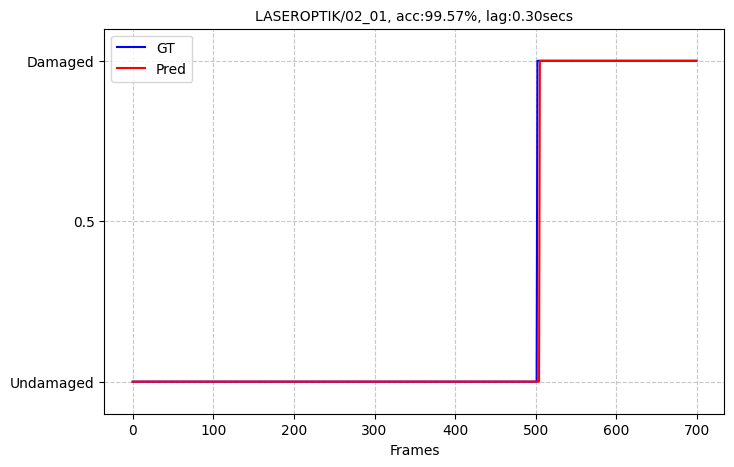

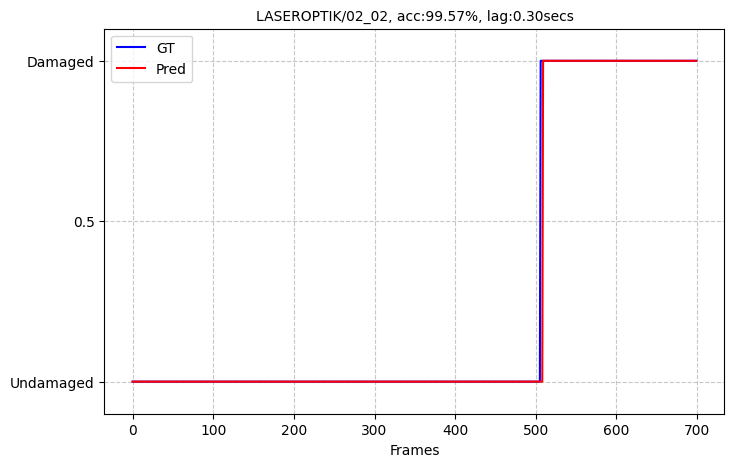

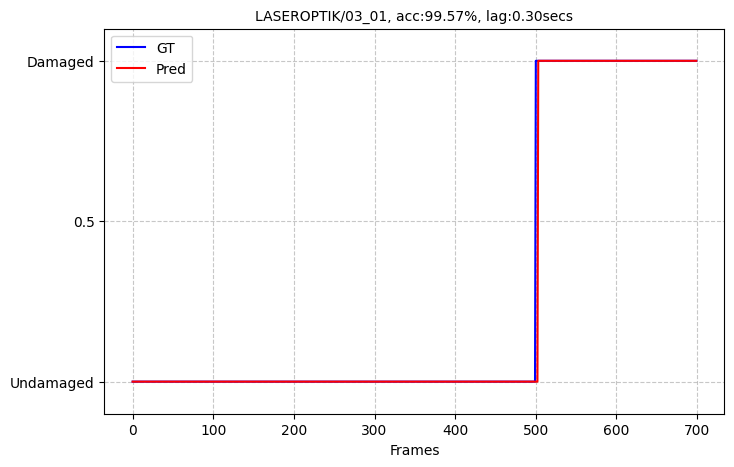

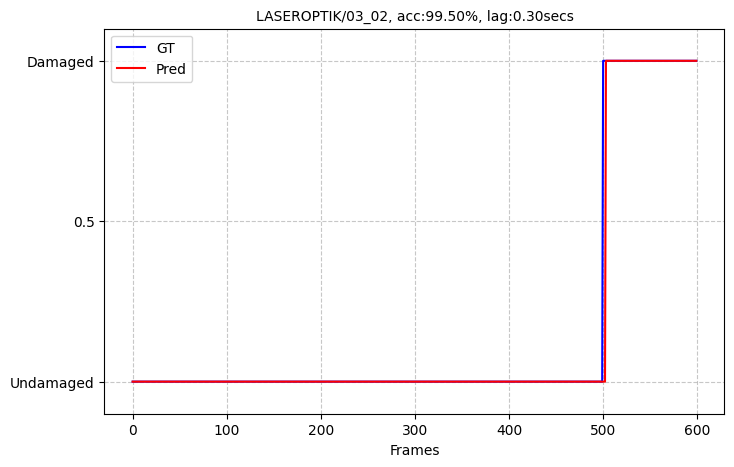

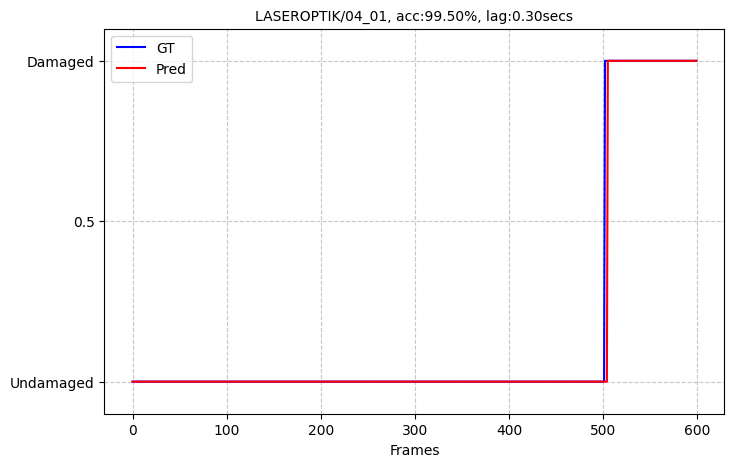

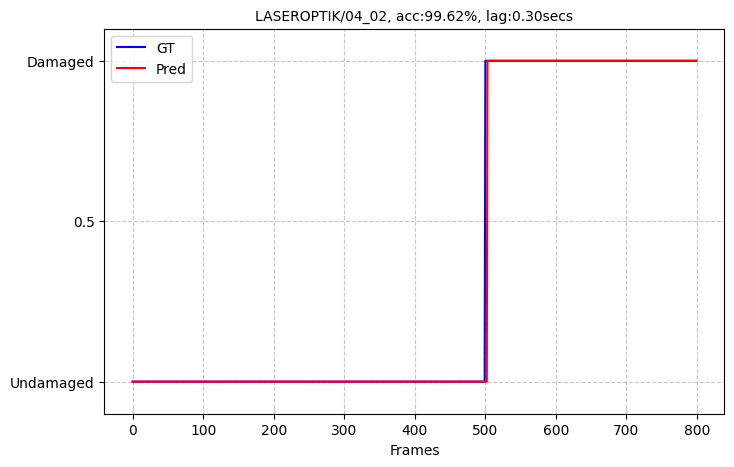

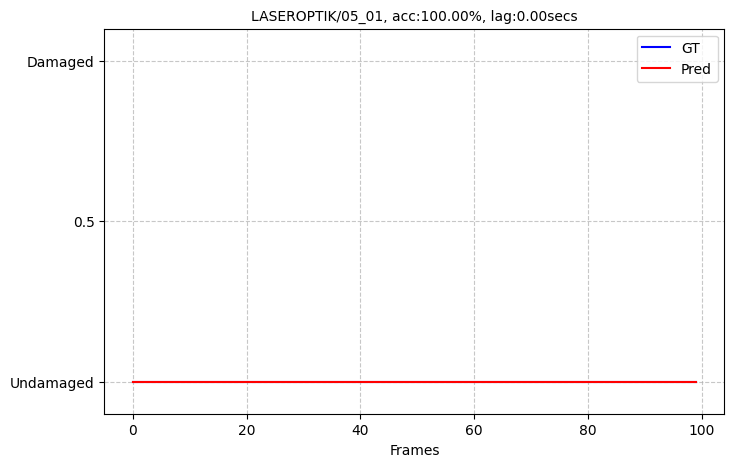

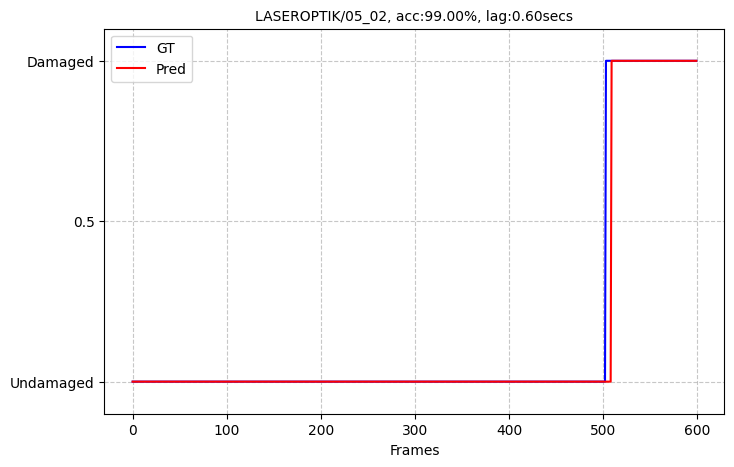

In [265]:
# Group by dataset and location
dset_results = defaultdict(lambda: defaultdict(list))
for item in sorted(eval_results, key=lambda x: x['img']):
    dset, loc, filename = item['img'].split('/')
    dset_results[dset][loc].append(item)
    
# Remove some false positives
conf_th = 0.4
fp_count_th = 10
window_len = 5
avg_pred_th = 0.5

all_acc = []
all_lag = []
plt.close('all')
for dset, dset_preds in dset_results.items():
    for loc, loc_preds in dset_preds.items():
        
        # if dset!='Grating_SON1' :
        #     continue
        # if loc not in ['01_02', '05_01', '05_03']:
        # # # if loc not in ['04_01']:
        #     continue
            
        # Initialize a deque to store the last 'window_size' predictions
        pred_window = deque([], maxlen=window_len)
        prob_window = deque([], maxlen=window_len)
        
        gt_labels, pred_labels = [], []
        
        damage_start_index = None
        detection_index = None
    
        fp_count = 0
        lag = 0
        for i, item in enumerate(loc_preds):
            gt_label= item['label']
            pred_label = item['pred']
            
            # Add the current prediction to the window
            pred_window.append(item['pred'])
            prob_window.append(item['prob'])
            
            # Calculate moving average
            moving_avg_pred = sum(pred_window) / len(pred_window)
            moving_avg_prob = sum(prob_window) / len(prob_window)
            # print(moving_avg_prob, item['prob'])
            
            # predict moving average label
            moving_avg_pred = int(moving_avg_pred>avg_pred_th)
            
            # if item['prob']>moving_avg_prob:
            #     pred_label = item['pred']
            # else:
            #     pred_label = moving_avg_pred
            
            # Filter prediction based on moving average
            if (item['pred']==1) & (item['prob']>conf_th):
                fp_count += 1

            if fp_count>fp_count_th:
                pred_label = 1
            elif (moving_avg_pred > avg_pred_th) & (item['prob']>conf_th):
                pred_label = 1
            else:
                pred_label = 0
            
            pred_labels.append(pred_label)
            gt_labels.append(item['label'])
            
            # Lag measurement logic
            if gt_label == 1 and damage_start_index is None:
                damage_start_index = i
            
            if (pred_label == 1) and (detection_index is None) and (damage_start_index is not None):
                detection_index = i
                lag = detection_index - damage_start_index
            
        acc = np.equal(gt_labels, pred_labels).mean() * 100
        all_acc.append(acc)
        all_lag.append(lag)
        
        title = f"{dset}/{loc}, acc:{acc:.2f}%, lag:{lag/10:.2f}secs"
        fig, ax = plot_damaged_dets(gt_labels, pred_labels, title=title)
        fig.savefig(f"{log_dir}/{dset}_{loc}.png")

        # break
        
print(f"Mean ACC: {np.mean(all_acc):.2f}, Mean Delay: {np.mean(all_lag):.2f}secs")